Import the required libraries:

In [1]:
!pip install pafy
!pip install --upgrade youtube-dl
!pip install moviepy
!pip3 install imageio==2.4.1
!pip install --upgrade imageio-ffmpeg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 48.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 65.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for imageio: filename=imageio-2.4.1-py3-none-any.whl size=3303886 sha256=3656d6deeb6e0873c9d34e31d6e7288e43da144bf5e10c21b5211165a9297fbc
  Stored in directory: /root/.cache/pip/wheels/be/7b/04/4d8d56f1d503e5c404f0de6018c0cfa592c71588a39b49e002
Successfully built imageio
  Attempting uninstall: imageio
    Found existing installation: imageio 2.9.0
    Uninstalling imageio-2.9.0:
      

In [2]:
import os
import cv2
import math
import pafy
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from moviepy.editor import *
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
 
from sklearn.model_selection import train_test_split
 
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)3194880/45929032 bytes (7.0%)6635520/45929032 bytes (14.4%)9494528/45929032 bytes (20.7%)11558912/45929032 bytes (25.2%)13500416/45929032 bytes (29.4%)15736832/45929032 bytes (34.3%)17784832/45929032 bytes (38.7%)19652608/45929032 bytes (42.8%)22110208/45929032 bytes (48.1%)24649728/45929032 bytes (53.7%)26320896/45929032 bytes (57.3%)28221440/45929032 bytes (61.4%)

Set Numpy, Python and Tensorflow seeds to get consistent results.

In [3]:
seed_constant = 23
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

# Step 1: Define the Dataset

You can download and extract the videos, but for simplification, I'm just going to define the video path in here.

In [12]:
dataset_directory = "/content/drive/MyDrive/DATA_MINING/"

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Step 2: Visualize the Data with its Labels

Let us pick some random videos from each class of the dataset and display it, this will give us a good overview of how the dataset looks like.

In [49]:
all_classes_names = os.listdir(dataset_directory) 
print(all_classes_names[random_index])

TIDAK_BERPOTENSI


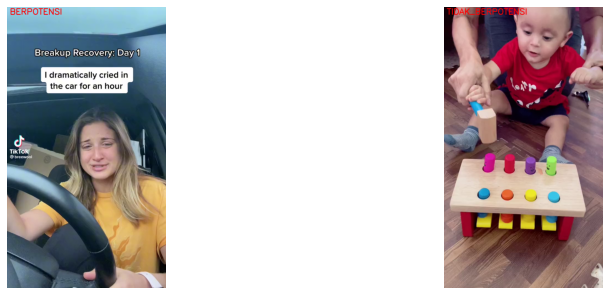

In [14]:
# Create a Matplotlib figure
plt.figure(figsize = (30, 30))
 
# Get Names of all classes in UCF50
all_classes_names = os.listdir(dataset_directory)
 
# Generate a random sample of images each time the cell runs
random_range = random.sample(range(len(all_classes_names)), 2)
 
# Iterating through all the random samples
for counter, random_index in enumerate(random_range, 1):
 
    # Getting Class Name using Random Index
    selected_class_Name = all_classes_names[random_index]
 
    # Getting a list of all the video files present in a Class Directory
    video_files_names_list = os.listdir(dataset_directory + selected_class_Name)
 
    # Randomly selecting a video file
    selected_video_file_name = random.choice(video_files_names_list)
 
    # Reading the Video File Using the Video Capture
    video_reader = cv2.VideoCapture(dataset_directory + selected_class_Name + "/" + selected_video_file_name)
     
    # Reading The First Frame of the Video File
    _, bgr_frame = video_reader.read()
 
    # Closing the VideoCapture object and releasing all resources. 
    video_reader.release()
 
    # Converting the BGR Frame to RGB Frame 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
 
    # Adding The Class Name Text on top of the Video Frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
     
    # Assigning the Frame to a specific position of a subplot
    plt.subplot(5, 4, counter)
    plt.imshow(rgb_frame)
    plt.axis('off')

# Step 3: Read and Preprocess the Dataset

Since we are going to use a classification architecture to train on a video classification dataset, we are going to need to preprocess the dataset first.

Now $w$ constants,

- `image_height` and `image_weight`: This is the size we will resize all frames of the video to, we are doing this to avoid unnecessary computation.
- `max_images_per_class`: Maximum number of training images allowed for each class.
- `dataset_directory`: The path of the directory containing the extracted dataset.
- `classes_list`: These are the list of classes we are going to be training on, we are training on following 2 classes, you can feel free to change it.
 - `berpotensi`
 - `tidak berpotensi`

*Note:* The `image_height`, `image_weight` and `max_images_per_class` constants may be increased for better results, but be warned this will become computationally expensive.

In [19]:
image_height, image_width = 64, 64
max_images_per_class = 2

classes_list = ["BERPOTENSI", "TIDAK_BERPOTENSI"]
 
model_output_size = len(classes_list)

**Extract, Resize and Normalize Frames**

Now we will create a function that will extract frames from each video while performing other preprocessing operation like resizing and normalizing images.

This method takes a video file path as input. It then reads the video file frame by frame, resizes each frame, normalizes the resized frame, appends the normalized frame into a list, and then finally returns that list.

In [20]:
def frames_extraction(video_path):
    # Empty List declared to store video frames
    frames_list = []
     
    # Reading the Video File Using the VideoCapture
    video_reader = cv2.VideoCapture(video_path)
 
    # Iterating through Video Frames
    while True:
 
        # Reading a frame from the video file 
        success, frame = video_reader.read() 
 
        # If Video frame was not successfully read then break the loop
        if not success:
            break
 
        # Resize the Frame to fixed Dimensions
        resized_frame = cv2.resize(frame, (image_height, image_width))
         
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
         
        # Appending the normalized frame into the frames list
        frames_list.append(normalized_frame)
     
    # Closing the VideoCapture object and releasing all resources. 
    video_reader.release()
 
    # returning the frames list 
    return frames_list

**Dataset Creation**

Now we will create another function called `create_dataset()`, this function uses the `frame_extraction()` function above and creates our final preprocessed dataset.

*Here’s how this function works:*

1. Iterate through all the classes mentioned in the _classes_list_.
2. Now for each class iterate through all the video files present in it.
3. Call the `frame_extraction` method on each video file.
4. Add the returned frames to a list called _temp_features_.
5. After all videos of a class are processed, randomly select video frames (equal to `max_images_per_class`) and add them to the list called features.
6. Add labels of the selected videos to the `labels` list.
7. After all videos of all classes are processed then return the features and labels as NumPy arrays.

So when you call this function, it returns two lists:

- A list of feature vectors
- A list of its associated labels.

In [21]:
def create_dataset():
 
    # Declaring Empty Lists to store the features and labels values.
    temp_features = [] 
    features = []
    labels = []
     
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(classes_list):
        print(f'Extracting Data of Class: {class_name}')
         
        # Getting the list of video files present in the specific class name directory
        files_list = os.listdir(os.path.join(dataset_directory, class_name))
 
        # Iterating through all the files present in the files list
        for file_name in files_list:
 
            # Construct the complete video path
            video_file_path = os.path.join(dataset_directory, class_name, file_name)
 
            # Calling the frame_extraction method for every video file path
            frames = frames_extraction(video_file_path)
 
            # Appending the frames to a temporary list.
            temp_features.extend(frames)
         
        # Adding randomly selected frames to the features list
        features.extend(random.sample(temp_features, max_images_per_class))
 
        # Adding Fixed number of labels to the labels list
        labels.extend([class_index] * max_images_per_class)
         
        # Emptying the temp_features list so it can be reused to store all frames of the next class.
        temp_features.clear()
 
    # Converting the features and labels lists to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  
 
    return features, labels

Calling the `create_dataset` method which returns features and labels.

In [22]:
features, labels = create_dataset()

Extracting Data of Class: BERPOTENSI
Extracting Data of Class: TIDAK_BERPOTENSI


Now we will convert class labels to one hot encoded vectors.

In [23]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

# Step 4: Split the Data into Train and Test Sets

Now we have two numpy arrays, one containing all images. The second one contains all class labels in one hot encoded format. Let us split our data to create a training, and a testing set. We must shuffle the data before the split, which we have already done.

In [24]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.2, shuffle = True, random_state = seed_constant)

# Step 5: Construct the Model

Now it is time to create our CNN model, for this post, we are creating a simple CNN Classification model with two CNN layers.

In [25]:
# Let's create a function that will construct our model
def create_model():
 
    # We will use a Sequential model for model construction
    model = Sequential()
 
    # Defining The Model Architecture
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', input_shape = (image_height, image_width, 3)))
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(model_output_size, activation = 'softmax'))
 
    # Printing the models summary
    model.summary()
 
    return model
 
 
# Calling the create_model method
model = create_model()
 
print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 batch_normalization (BatchN  (None, 60, 60, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 64)       0         
 )                                                               
                                                                 
 global_average_pooling2d (G  (None, 64)               0         
 lobalAveragePooling2D)                                          
                                                        

**Check Model’s Structure:**

Using the `plot_model` function, we can check the structure of the final model. This is really helpful when we are creating a complex network, and you want to make sure we have constructed the network correctly.

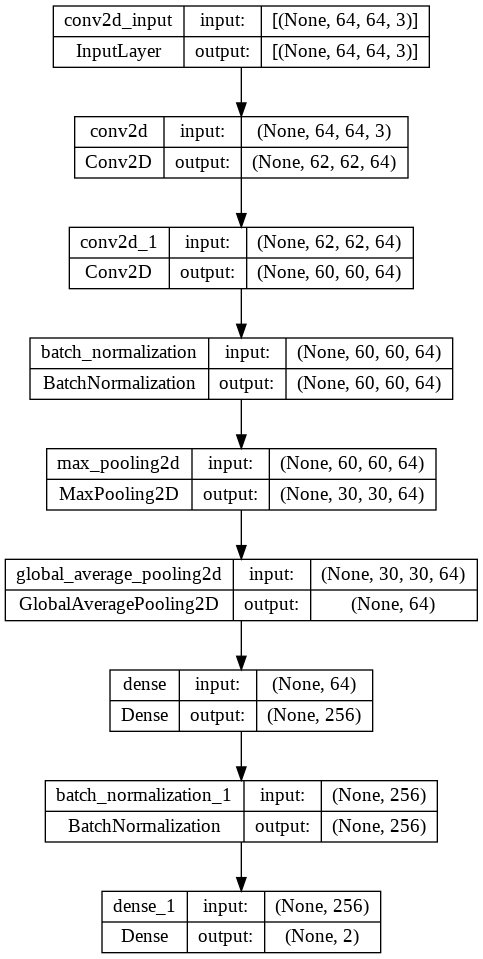

In [26]:
plot_model(model, to_file = 'model_structure_plot.png', show_shapes = True, show_layer_names = True)

# Step 6: Compile and Train the Model

Now let us start the training. Before we do that, we also need to compile the model.

In [27]:
# Adding Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
 
# Adding loss, optimizer and metrics values to the model.
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])
 
# Start Training
model_training_history = model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 4 , shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])


Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 1.6907 - accuracy: 0.0000e+00 - val_loss: 0.7240 - val_accuracy: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 0s 138ms/step - loss: 0.2402 - accuracy: 1.0000 - val_loss: 0.7434 - val_accuracy: 0.0000e+00
Epoch 3/50
1/1 [==============================] - 0s 272ms/step - loss: 0.0952 - accuracy: 1.0000 - val_loss: 0.7466 - val_accuracy: 0.0000e+00
Epoch 4/50
1/1 [==============================] - 0s 127ms/step - loss: 0.0501 - accuracy: 1.0000 - val_loss: 0.7621 - val_accuracy: 0.0000e+00
Epoch 5/50
1/1 [==============================] - 0s 124ms/step - loss: 0.0317 - accuracy: 1.0000 - val_loss: 0.7840 - val_accuracy: 0.0000e+00
Epoch 6/50
1/1 [==============================] - 0s 122ms/step - loss: 0.0212 - accuracy: 1.0000 - val_loss: 0.8067 - val_accuracy: 0.0000e+00
Epoch 7/50
1/1 [==============================] - 0s 168ms/step - loss: 0.0148 - accuracy: 1.0000 - val_loss: 0.8285 - val_accuracy: 0.

**Evaluating Your Trained Model**

Evaluate your trained model on the feature’s and label’s test sets.

In [28]:
model_evaluation_history = model.evaluate(features_test, labels_test)

1/1 [==============================] - 0s 25ms/step - loss: 0.6835 - accuracy: 1.0000


**Save Your Model**

You should now save your model for future runs.

In [29]:
# Creating a useful name for our model, incase you're saving multiple models (OPTIONAL)
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history
model_name = f'Model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'
 
# Saving your Model
model.save(model_name)

# Step 7: Plot Model’s Loss and Accuracy Curves

Let us plot our loss and accuracy curves.

In [30]:
def plot_metric(metric_name_1, metric_name_2, plot_name):
  # Get Metric values using metric names as identifiers
  metric_value_1 = model_training_history.history[metric_name_1]
  metric_value_2 = model_training_history.history[metric_name_2]
 
  # Constructing a range object which will be used as time 
  epochs = range(len(metric_value_1))
   
  # Plotting the Graph
  plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
  plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)
   
  # Adding title to the plot
  plt.title(str(plot_name))
 
  # Adding legend to the plot
  plt.legend()

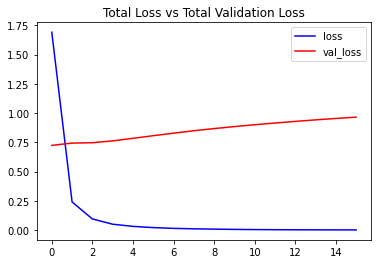

In [31]:
plot_metric('loss', 'val_loss', 'Total Loss vs Total Validation Loss')

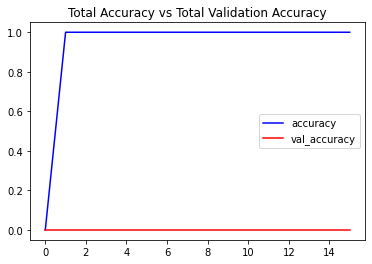

In [32]:
plot_metric('accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

# Step 8: Make Predictions with the Model:

Now that we have created and trained our model it is time to test it is performance on some test videos.

**Function to Download YouTube Videos:**

Let us start by testing on some YouTube videos. This function will use pafy library to download any youtube video and return its title. We just need to pass the URL.

In [33]:
def download_youtube_videos(youtube_video_url, output_directory):
    # Creating a Video object which includes useful information regarding the youtube video.
    video = pafy.new(youtube_video_url)
 
    # Getting the best available quality object for the youtube video.
    video_best = video.getbest()
 
    # Constructing the Output File Path
    output_file_path = f'{output_directory}/{video.title}.mp4'
 
    # Downloading the youtube video at the best available quality.
    video_best.download(filepath = output_file_path, quiet = True)
 
    # Returning Video Title
    return video.title

**Function To Predict on Live Videos Using Moving Average:**

This function will perform predictions on live videos using moving_average. We can either pass in videos saved on disk or use a webcam. If we set window_size hyperparameter to 1, this function will behave like a normal classifier to predict video frames.

Note: You can not use your webcam if you are running this notebook on google colab.

In [34]:
def predict_on_live_video(video_file_path, output_file_path, window_size):
 
    # Initialize a Deque Object with a fixed size which will be used to implement moving/rolling average functionality.
    predicted_labels_probabilities_deque = deque(maxlen = window_size)
 
    # Reading the Video File using the VideoCapture Object
    video_reader = cv2.VideoCapture(video_file_path)
 
    # Getting the width and height of the video 
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
 
    # Writing the Overlayed Video Files Using the VideoWriter Object
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'), 24, (original_video_width, original_video_height))
 
    while True: 
 
        # Reading The Frame
        status, frame = video_reader.read() 
 
        if not status:
            break
 
        # Resize the Frame to fixed Dimensions
        resized_frame = cv2.resize(frame, (image_height, image_width))
         
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
 
        # Passing the Image Normalized Frame to the model and receiving Predicted Probabilities.
        predicted_labels_probabilities = model.predict(np.expand_dims(normalized_frame, axis = 0))[0]
 
        # Appending predicted label probabilities to the deque object
        predicted_labels_probabilities_deque.append(predicted_labels_probabilities)
 
        # Assuring that the Deque is completely filled before starting the averaging process
        if len(predicted_labels_probabilities_deque) == window_size:
 
            # Converting Predicted Labels Probabilities Deque into Numpy array
            predicted_labels_probabilities_np = np.array(predicted_labels_probabilities_deque)
 
            # Calculating Average of Predicted Labels Probabilities Column Wise 
            predicted_labels_probabilities_averaged = predicted_labels_probabilities_np.mean(axis = 0)
 
            # Converting the predicted probabilities into labels by returning the index of the maximum value.
            predicted_label = np.argmax(predicted_labels_probabilities_averaged)
 
            # Accessing The Class Name using predicted label.
            predicted_class_name = classes_list[predicted_label]
           
            # Overlaying Class Name Text Ontop of the Frame
            cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
 
        # Writing The Frame
        video_writer.write(frame)
 
 
        # cv2.imshow('Predicted Frames', frame)
 
        # key_pressed = cv2.waitKey(10)
 
        # if key_pressed == ord('q'):
        #     break
 
    # cv2.destroyAllWindows()
 
     
    # Closing the VideoCapture and VideoWriter objects and releasing all resources held by them. 
    video_reader.release()
    video_writer.release()

**Test Video:**

In [50]:
input_video_file_path = "/content/drive/MyDrive/DATA_MINING/BERPOTENSI/v09044g40000c90a4ojc77udfbrjoslg.mp4"

**Results:**

First let us see the results, we can do this by setting the window_size to 1.

In [51]:
# Setting sthe Window Size which will be used by the Rolling Average Proces
window_size = 1
 
# Constructing The Output YouTube Video Path
output_video_file_path = f'test-Output-WSize {window_size}.mp4'
 
# Calling the predict_on_live_video method to start the Prediction.
predict_on_live_video(input_video_file_path, output_video_file_path, window_size)
 
# Play Video File in the Notebook
VideoFileClip(output_video_file_path).ipython_display(width = 700)

1/1 [==============================] - 0s 25ms/step


 95%|█████████▍| 330/348 [00:02<00:00, 179.75it/s]WARNING:py.warnings:/usr/local/lib/python3.8/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file test-Output-WSize 1.mp4, 1555200 bytes wanted but 0 bytes read,at frame 347/348, at time 14.46/14.46 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+

100%|██████████| 348/348 [00:02<00:00, 158.99it/s]


---